# Severity Projection

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

import data_cleansing as dc
import data_utils as du

## load the data and apply cleaning steps


In [2]:

data_train_raw, data_test_raw = dc.load_file()

data_test = data_test_raw.copy()
data_train = data_train_raw.copy()

In [3]:
target_name='severity'



## Setup the dataset 


## Apply lable encoding to the factors

In [4]:

label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand']
# encode training data and save encoders used
data_train_encoded, encoders = du.preprocess_labelencode(data_train, label_encode_factors)
# apply trained encoders to test set
data_test_encoded = du.preprocess_labelencode_apply(encoders, data_test, label_encode_factors)

## Cap the claim values to controll outliers


In [5]:
#cap large claims
severity_cap = 50e3
data_train_encoded[target_name] = data_train_encoded[target_name].where(data_train_encoded[target_name]<severity_cap, severity_cap)
data_test_encoded[target_name] = data_test_encoded[target_name].where(data_test_encoded[target_name]<severity_cap, severity_cap)


## Remove policies with no claims to train the model (include/exclude zero value claims)

In [6]:
#data_train_resampled = data_train_encoded.loc[data_train_encoded[target_name]>0]    # this excludes zero claims
data_train_resampled = data_train_encoded.loc[data_train_encoded['ClaimNb']>0].copy() # this includes zero claims


# Setup the Random Forest model

## Split target from factors

In [7]:
#sets used to train (resampled sets)
x_train = data_train_resampled[label_encode_factors].copy()
y_train = data_train_resampled[target_name].copy()

#sets used to predict (and evaluate prediction)
x_train_to_predict = data_train_encoded[label_encode_factors].copy()
y_train_to_predict = data_train_encoded[target_name].copy()
x_test = data_test_encoded[label_encode_factors].copy()
y_test = data_test_encoded[target_name].copy()


## Build the model and predict

In [8]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=3, 
                                n_estimators=200,
                                max_depth=30,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values, y_train.values)    



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   11.4s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   11.7s finished


Wall time: 14.7 s


In [9]:
#predict values
y_train_predicted_rf = clf_rf.predict(x_train_to_predict.values)    
y_test_predicted_rf = clf_rf.predict(x_test.values)  

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   17.2s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:   17.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:    7.6s
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:    7.8s finished


## Merge results back to data set

In [10]:
target_name_predicted = target_name + '_predicted'

x_train_to_predict[target_name_predicted] = y_train_predicted_rf
x_train_to_predict[target_name] = y_train_to_predict
x_test[target_name_predicted] = y_test_predicted_rf
x_test[target_name] = y_test

# Test the results 

In [11]:
# total claim results

#predict claim estimates for all policies, but only measure against claims which are in the test set
x_train_claimsonly = x_train_to_predict.loc[x_train_to_predict[target_name]>0]
x_test_claimsonly = x_test.loc[x_test[target_name]>0]

train_results_actual= x_train_claimsonly[target_name].sum()
train_results_predict = x_train_claimsonly[target_name_predicted].sum()

test_results_actual= x_test_claimsonly[target_name].sum()
test_results_predict = x_test_claimsonly[target_name_predicted].sum()

# gini results
train_results_gini = du.gini(x_train_claimsonly[target_name].values, x_train_claimsonly[target_name_predicted].values)
test_results_gini = du.gini(x_test_claimsonly[target_name].values, x_test_claimsonly[target_name_predicted].values)
# mean squared error
train_results_mse = np.sqrt(mean_squared_error(x_train_claimsonly[target_name].values, x_train_claimsonly[target_name_predicted].values))
test_results_mse = np.sqrt(mean_squared_error(x_test_claimsonly[target_name].values, x_test_claimsonly[target_name_predicted].values))

print('Total Claims: ', 'Tr Actual {:,.5f}'.format(train_results_actual),
      'Te Actual {:,.5f}'.format(test_results_actual))
print('Total Claims: ', 'Tr Predic {:,.5f}'.format(train_results_predict),
      'Te Predic {:,.5f}'.format(test_results_predict))

print('Results: ',
      'Tr_G {:,.5f}'.format(train_results_gini),
      'Te_G {:,.5f}'.format(test_results_gini),
      'Tr_rmse {:,.5f}'.format(train_results_mse),
      'Te_rmse {:,.5f}'.format(test_results_mse))

print('Factor Importance:\n', pd.DataFrame(zip(clf_rf.feature_importances_, x_train.columns)).sort_values(0, ascending=False))

Total Claims:  Tr Actual 28,694,432.92696 Te Actual 11,942,020.23992
Total Claims:  Tr Predic 26,499,302.69744 Te Predic 10,701,092.07370
Results:  Tr_G 0.21015 Te_G 0.00129 Tr_rmse 2,912.42408 Te_rmse 3,874.58653
Factor Importance:
           0            1
7  0.248240   VehAgeBand
2  0.161609     VehBrand
1  0.142966     VehPower
4  0.127982       Region
5  0.117024  DrivAgeBand
6  0.098081  DensityBand
0  0.073433         Area
3  0.030664       VehGas


### Output the results

In [12]:

data_train_out = data_train_raw.join(x_train_to_predict['severity_predicted'])
data_test_out = data_test_raw.join(x_test['severity_predicted'])

data_train_out.to_pickle('sev_train.pkl')
data_test_out.to_pickle('sev_test.pkl')

print(len(data_test_out), len(data_train_out))

169028 394400


# Review the Results in Charts

## Plot of distribution of results

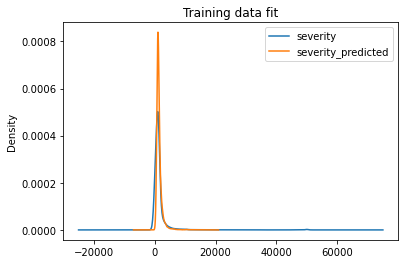

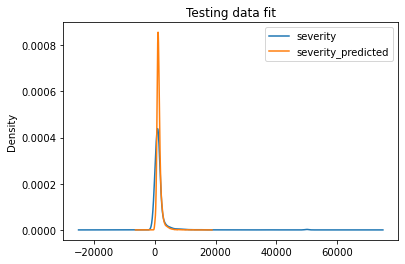

In [13]:
#%% plot distribution charts
x_train_claimsonly[[target_name, target_name_predicted]].plot(kind='kde', title='Training data fit')
x_test_claimsonly[[target_name, target_name_predicted]].plot(kind='kde', title='Testing data fit')


## Plot of mean claim numbers split by factor level

## Show fit of data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand
severity_predicted
--target
severity
--target


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


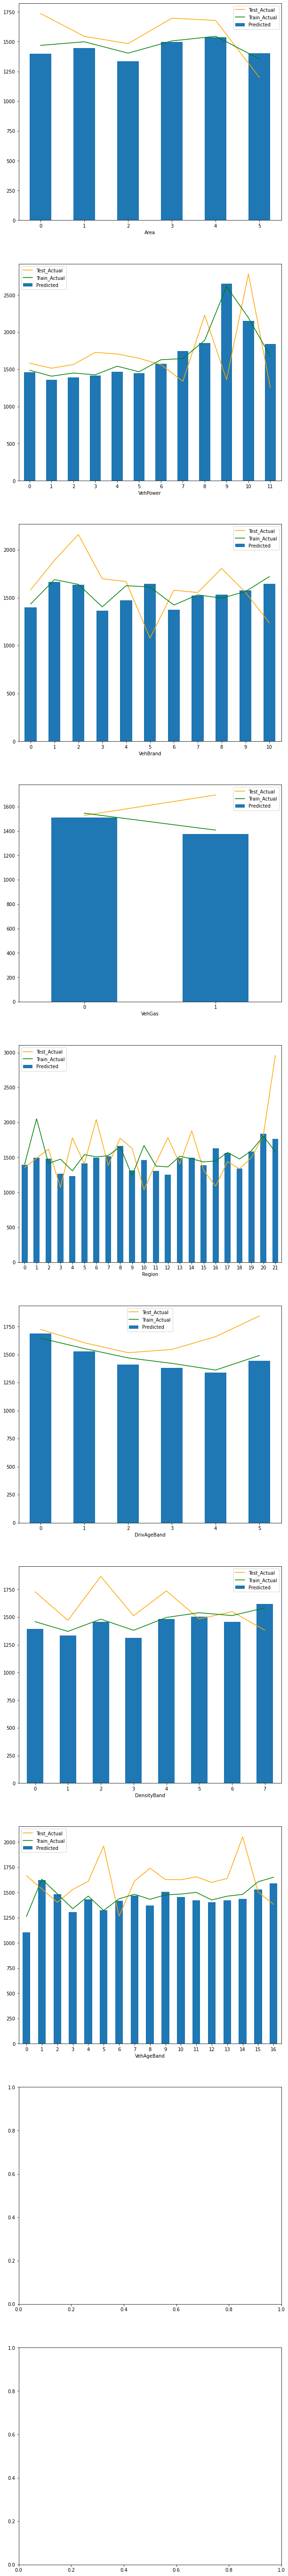

In [14]:
#%% bar charts of mean result
fig = du.plot_factors(x_test_claimsonly, target_name, target_name_predicted, x_train_claimsonly)
fig.show()